In [2]:
import pipeline, astropy.io, astropy.table, numpy, matplotlib.pyplot as plt, collections
import itertools
%matplotlib inline

# Try to set up matplotlib fonts.
import matplotlib

# http://bkanuka.com/articles/native-latex-plots/
def figsize(scale):
    fig_width_pt = 240.0
    inches_per_pt = 1.0/72.27
    golden_mean = (numpy.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt*inches_per_pt*scale
    fig_height = fig_width*golden_mean
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.figsize": figsize(0.9),
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",
        r"\usepackage[T1]{fontenc}",
    ]
}
matplotlib.rcParams.update(pgf_with_latex)



titlemap = {
    'RGZ & Norris & compact': 'Compact',
    'RGZ & Norris & resolved': 'Resolved',
    'RGZ & Norris': 'All',
    'RGZ & compact': 'Compact',
    'RGZ & resolved': 'Resolved',
    'RGZ': 'All',
}

fullmap = {
    'RGZ & Norris & compact': 'RGZ & compact',
    'RGZ & Norris & resolved': 'RGZ & resolved',
    'RGZ & Norris': 'RGZ',
}

whatset = {
    'RGZ & Norris & compact': 'RGZ & Norris & compact',
    'RGZ & Norris & resolved': 'RGZ & Norris & resolved',
    'RGZ & Norris': 'RGZ & Norris',
    'RGZ & compact': 'RGZ & Norris & compact',
    'RGZ & resolved': 'RGZ & Norris & resolved',
    'RGZ': 'RGZ & Norris',
}

norris_labelled_sets = [
    'RGZ & Norris & compact',
    'RGZ & Norris & resolved',
    'RGZ & Norris',
]

In [3]:
swire_names, swire_coords, _ = pipeline.generate_swire_features(overwrite=False, field='cdfs')
swire_labels = pipeline.generate_swire_labels(swire_names, swire_coords, overwrite=False, field='cdfs')
(_, atlas_test_sets), (_, swire_test_sets) = pipeline.generate_data_sets(swire_coords, swire_labels, overwrite=False, field='cdfs')

In [4]:
lr_predictions = itertools.chain(
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'LogisticRegression_norris_cdfs_predictions'),
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'LogisticRegression_rgz_cdfs_predictions'))
rf_predictions = itertools.chain(
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'RandomForestClassifier_norris_cdfs_predictions'),
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'RandomForestClassifier_rgz_cdfs_predictions'))
cnn_predictions = itertools.chain(
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'CNN_norris_cdfs_predictions'),
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'CNN_rgz_cdfs_predictions'))

In [5]:
# Classify nearest neighbours to ATLAS coords as hosts.
atlas_names = []
table = astropy.io.ascii.read(pipeline.TABLE_PATH)
atlas_coords = []
norris_truth = []
atlas_name_to_compact = {}
for i, row in enumerate(table):
    assert i == row['Key']
    name = row['Component Name (Franzen)']
    atlas_names.append(name)
    atlas_coords.append((row['Component RA (Franzen)'], row['Component DEC (Franzen)']))
    norris_truth.append((row['Source SWIRE (Norris)']))
    if name:
        atlas_name_to_compact[name] = pipeline.compact_test(row)
atlas_coords = numpy.array(atlas_coords)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Warning: converting a masked element to nan.
  from ipykernel import kernelapp as app


In [6]:
nn_labels = numpy.zeros((swire_labels.shape[0],), dtype='bool')

In [7]:
swire_tree = pipeline.scipy.spatial.KDTree(swire_coords)

In [8]:
dists, nearest = swire_tree.query(atlas_coords)

In [9]:
nn_labels[nearest[dists != numpy.inf]] = True

In [10]:
# Load RGZ cross-identifications and compute a balanced accuracy with them.
label_rgz_accuracies = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
label_nn_accuracies = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
label_norris_accuracies = {sstr: [1] * 4 for sstr in pipeline.SET_NAMES}  # By definition.
for dataset_name in pipeline.SET_NAMES:
    for quadrant in range(4):
        test_set = swire_test_sets[:, pipeline.SET_NAMES[dataset_name], quadrant]
        predictions_rgz = swire_labels[test_set, 1]
        predictions_nn = nn_labels[test_set]
        trues = swire_labels[test_set, 0]
        ba_rgz = pipeline.balanced_accuracy(trues, predictions_rgz)
        ba_nn = pipeline.balanced_accuracy(trues, predictions_nn)
        label_rgz_accuracies[dataset_name][quadrant] = ba_rgz
        label_nn_accuracies[dataset_name][quadrant] = ba_nn

In [11]:
lr_norris_accuracies = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
lr_rgz_accuracies = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
rf_norris_accuracies = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
rf_rgz_accuracies = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
cnn_norris_accuracies = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
cnn_rgz_accuracies = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
for predictions in lr_predictions:
    dataset_name = predictions.dataset_name
    if predictions.labeller == 'norris':
        lr_norris_accuracies[dataset_name][predictions.quadrant] = predictions.balanced_accuracy
    else:
        lr_rgz_accuracies[dataset_name][predictions.quadrant] = predictions.balanced_accuracy
for predictions in rf_predictions:
    dataset_name = predictions.dataset_name
    if predictions.labeller == 'norris':
        rf_norris_accuracies[dataset_name][predictions.quadrant] = predictions.balanced_accuracy
    else:
        rf_rgz_accuracies[dataset_name][predictions.quadrant] = predictions.balanced_accuracy
for predictions in cnn_predictions:
    dataset_name = predictions.dataset_name
    if predictions.labeller == 'norris':
        cnn_norris_accuracies[dataset_name][predictions.quadrant] = predictions.balanced_accuracy
    else:
        cnn_rgz_accuracies[dataset_name][predictions.quadrant] = predictions.balanced_accuracy

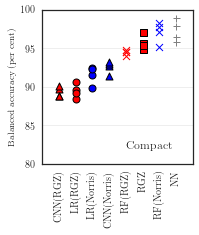

In [21]:
colours = ['red', 'red', 'blue', 'blue', 'red', 'red', 'blue', 'grey']
markers = '^oo^xsx+'
handles = {}
# plt.figure(figsize=(5, 3))

accuracy_map = collections.defaultdict(lambda: collections.defaultdict(dict))  # For table output.
output_sets = [
    ('CNN(RGZ)', cnn_rgz_accuracies),
    ('LR(RGZ)', lr_rgz_accuracies),
    ('LR(Norris)', lr_norris_accuracies),
    ('CNN(Norris)', cnn_norris_accuracies),
    ('RF(RGZ)', rf_rgz_accuracies),
    ('RGZ', label_rgz_accuracies),
    ('RF(Norris)', rf_norris_accuracies),
    ('NN', label_nn_accuracies),
]
fs = figsize(0.9)
fs = fs[0], fs[1] * 2
fig = plt.figure(figsize=fs)
for j, (classifier_name, classifier_set) in enumerate(output_sets):
    set_name = 'RGZ & Norris & compact'
    ax = plt.subplot(1, 1, 1)
    for k in range(4):
        handles[j] = ax.scatter([(j + 1) / 10], classifier_set[set_name][k] * 100,
                                color=colours[j], marker=markers[j], linewidth=1, edgecolor='k')
    ax.set_ylim((80, 100))
    ax.set_xlim((0, 0.9))
    ax.set_xticks(numpy.linspace(0.1, 0.8, 8))
    ax.set_xticklabels([s[0] for s in output_sets], rotation='vertical')
    if i == 2:
        plt.xlabel('Labels')
    plt.ylabel('Balanced accuracy (per cent)'.format(titlemap[set_name]))

    ax.title.set_fontsize(16)
    ax.xaxis.label.set_fontsize(12)
    ax.yaxis.label.set_fontsize(9)
    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontsize(10)

    ax.grid(which='major', axis='y', color='#EEEEEE')

plt.subplots_adjust(bottom=0.3, left=0.20)
plt.annotate('Compact', (0.5, 82))
plt.savefig('../images/compact-ba.pdf')

In [12]:
# Now, let's save these results as a predictions object so we can use them in our grid plots.
preds = []
for quadrant in range(4):
    test_set = swire_test_sets[:, pipeline.SET_NAMES['RGZ'], quadrant]
    p = pipeline.Predictions(
            probabilities=nn_labels[test_set],
            labels=nn_labels[test_set],
            balanced_accuracy=0,
            dataset_name='RGZ & Norris',  # This is only for recording the *training* set.
            quadrant=quadrant,
            params={},
            labeller='NN',
            classifier='NearestNeighbour')
    preds.append(p)

In [13]:
pipeline.serialise_predictions(preds, pipeline.WORKING_DIR + 'NearestNeighbour_cdfs')

In [14]:
xids = []
for quadrant in range(4):
    test_set = atlas_test_sets[:, pipeline.SET_NAMES['RGZ'], quadrant]
    dists, nearest = swire_tree.query(atlas_coords[test_set])
    radio_names = numpy.array([atlas_names[i] for i in test_set.nonzero()[0]])
    names = numpy.array([swire_names[i] for i in nearest])
    true_names = numpy.array([norris_truth[i] for i in test_set.nonzero()[0]])
    xids.append(pipeline.CrossIdentifications(
        radio_names=radio_names,
        ir_names=names,
        quadrant=quadrant,
        dataset_name='RGZ & Norris',
        labeller='NN',
        classifier='NearestNeighbour',
        params={},
        accuracy=(true_names == names).mean()))

In [15]:
pipeline.serialise_cross_identifications(xids, pipeline.WORKING_DIR + 'NearestNeighbour_cdfs_cross_ids')

## ELAIS-S1

In [16]:
with astropy.io.fits.open(pipeline.MIDDELBERG_TABLE4_PATH) as fits:
    elais_component_table = astropy.table.Table(fits[1].data).to_pandas()

In [17]:
elais_component_table.head()

,CID,---,ATELAIS,RAh,RAm,RAs,DE-,DEd,DEm,DEs,...,e_Sint,rms,Bmaj,Bmin,PA,Spd,DBmaj,DBmin,DPA,L
0,C0001,ATELAIS,J003333.11-444550.4,0,33,33.117,-,44,45,50.46,...,0.14,258.69,16.64,9.83,1,2.53,13.10,6.72,2,
1,C0002,ATELAIS,J003346.18-444513.6,0,33,46.190,-,44,45,13.60,...,0.05,176.57,10.26,7.17,0,0.00,0.00,0.00,0,
2,C0003,ATELAIS,J003504.08-444506.6,0,35,4.084,-,44,45,6.62,...,0.10,208.30,18.50,9.71,162,2.35,15.61,6.02,157,
3,C0004,ATELAIS,J003709.03-444427.5,0,37,9.036,-,44,44,27.55,...,0.14,212.77,19.72,14.34,32,1.35,17.39,11.63,40,*
4,C0005,ATELAIS,J003709.86-444349.8,0,37,9.865,-,44,43,49.86,...,0.06,198.81,14.75,8.52,0,9.60,10.60,4.59,179,


In [18]:
swire_names_elais, swire_coords_elais, _ = pipeline.generate_swire_features(
    overwrite=False, field='elais')
swire_labels_elais = pipeline.generate_swire_labels(
    swire_names_elais, swire_coords_elais, overwrite=False, field='elais')
(_, atlas_test_sets_elais), (_, swire_test_sets_elais) = pipeline.generate_data_sets(
    swire_coords_elais, swire_labels_elais, overwrite=False, field='elais')

In [ ]:
swire_tree_elais = pipeline.scipy.spatial.KDTree(swire_coords_elais)

In [ ]:
elais_nn_labels = numpy.zeros((len(swire_names_elais),), dtype=bool)
elais_names = []
elais_predicted_names = []
for i, component in elais_component_table.iterrows():
    cc = astropy.coordinates.SkyCoord(ra='{} {} {}'.format(component['RAh'], component['RAm'], component['RAs']),
                                      dec='-{} {} {}'.format(component['DEd'], component['DEm'], component['DEs']),
                                      unit=('hourangle', 'deg'))
    coord = (cc.ra.deg, cc.dec.deg)
    dist, nearby = swire_tree_elais.query(coord)
    elais_nn_labels[nearby] = True
    elais_names.append(component['ATELAIS'])
    elais_predicted_names.append(swire_names_elais[nearby])

In [ ]:
elais_nn_labels.mean()

In [ ]:
test_set = swire_test_sets_elais[:, 0, 0]
p = pipeline.Predictions(
        probabilities=elais_nn_labels[test_set],
        labels=elais_nn_labels[test_set],
        balanced_accuracy=0,
        dataset_name='RGZ & Norris',
        quadrant=0,
        params={},
        labeller='norris',
        classifier='NearestNeighbour')

In [ ]:
pipeline.serialise_predictions([p], pipeline.WORKING_DIR + 'NearestNeighbour_elais')

In [ ]:
test_set = atlas_test_sets_elais[:, 0, 0]
radio_names = numpy.array(elais_names)
names = numpy.array(elais_predicted_names)
xids = []
xids.append(pipeline.CrossIdentifications(
    radio_names=radio_names,
    ir_names=names,
    quadrant=0,
    dataset_name='RGZ & Norris',
    labeller='norris',
    classifier='NearestNeighbour',
    params={},
    accuracy=0))

In [ ]:
pipeline.serialise_cross_identifications(xids, pipeline.WORKING_DIR + 'NearestNeighbour_elais_cross_ids')

In [ ]:
pipeline.balanced_accuracy(elais_nn_labels[test_set], swire_labels_elais[test_set, 0])